# PROJET 5 : Segmentez des clients d'un site e-commerce
*Mathieu GENTHON (juin 2020)*

## SOMMAIRE<a class="anchor" id="sommaire"></a>
### 1 - [Contexte du projet](#1)<a class="anchor" id="sommaire"></a>
### 2 - [Importation des librairies et chargement dataframe](#2)<a class="anchor" id="sommaire"></a>
### 3 - [Description et nettoyage du Data Set](#3)<a class="anchor" id="sommaire"></a>
### 4 - [Consolidation du Data Set](#4)<a class="anchor" id="sommaire"></a>
### 5 - [Analyse exploratoire](#5)<a class="anchor" id="sommaire"></a>


### 1 - [Contexte du projet](#1)<a class="anchor" id="1"></a>

Olist souhaite que vous fournissiez à ses équipes d'e-commerce une segmentation des clients qu’elles pourront utiliser au quotidien pour leurs campagnes de communication.

Votre objectif est de comprendre les différents types d’utilisateurs grâce à leur comportement et à leurs données personnelles.

Vous devrez fournir à l’équipe marketing une description actionable de votre segmentation et de sa logique sous-jacente pour une utilisation optimale, ainsi qu’une proposition de contrat de maintenance basée sur une analyse de la stabilité des segments au cours du temps.

Pour cette mission, Olist vous fournit une base de données anonymisée comportant des informations sur l’historique de commandes, les produits achetés, les commentaires de satisfaction, et la localisation des clients depuis janvier 2017.

Votre mission est d’aider les équipes d’Olist à comprendre les différents types d'utilisateurs. Vous utiliserez donc des méthodes non supervisées pour regrouper ensemble des clients de profils similaires. Ces catégories pourront être utilisées par l’équipe marketing pour mieux communiquer.

Pour des raisons de confidentialité, Olist ne fournit pas beaucoup de données, à vous de fouiller dans celles dont vous disposez et de créer les meilleures features pour les exploiter.

Enfin, votre client, Olist, a spécifié sa demande ainsi :

    - La segmentation proposée doit être exploitable et facile d’utilisation pour l’équipe marketing.
    - Vous évaluerez la fréquence à laquelle la segmentation doit être mise à jour, afin de pouvoir effectuer un devis de contrat de maintenance.
    - Le code fourni doit respecter la convention PEP8, pour être utilisable par Olist.


### 2 - [Importation des librairies et chargement dataframe](#2)<a class="anchor" id="2"></a>

In [91]:
# Ligne pour vérifier compatibilité PEP8.
# %load_ext pycodestyle_magic
# %pycodestyle_on
# On importe les librairies dont on devrait avoir besoin pour le projet.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn import preprocessing
from datetime import date, time, datetime
%matplotlib inline
sns.set()
pd.set_option('display.max_columns', None)  # On affiche tte les col des df
pd.options.display.max_rows = 100  # On affiche jusqu'à 100 lignes d'un df

In [92]:
# On charge les données depuis des fichiers en local
# et on crée des data frame pour chaque fichier.
path = 'C:/Users/GENTHON-M/Documents/formation/Open Classrooms/\
5-Segmentation clients/'

df_Cust = pd.read_csv(path+"olist_customers_dataset.csv",
                      low_memory=False)
df_GeoLoc = pd.read_csv(path+"olist_geolocation_dataset.csv",
                        low_memory=False)
df_OrdItem = pd.read_csv(path+"olist_order_items_dataset.csv",
                         low_memory=False)
df_OrdPaymt = pd.read_csv(path+"olist_order_payments_dataset.csv",
                          low_memory=False)
df_OrdRvews = pd.read_csv(path+"olist_order_reviews_dataset.csv",
                          low_memory=False)
df_OrdDtset = pd.read_csv(path+"olist_orders_dataset.csv",
                          low_memory=False)
df_PdctDtset = pd.read_csv(path+"olist_products_dataset.csv",
                           low_memory=False)
df_SelrsDtset = pd.read_csv(path+"olist_sellers_dataset.csv",
                            low_memory=False)
df_PdctCat = pd.read_csv(path+"product_category_name_translation.csv",
                         low_memory=False)

### 3 - [Description et nettoyage du data set](#3)<a class="anchor" id="3"></a>

#### 3.1 - [Customers](#31)<a class="anchor" id="31"></a>

In [93]:
df_Cust.head(3)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP


In [94]:
print(df_Cust['customer_id'].nunique(),
      df_Cust['customer_unique_id'].nunique())
print(df_Cust.shape)
cle = ['customer_id']
df_Cust[cle].drop_duplicates().shape[0] == df_Cust.shape[0]

99441 96096
(99441, 5)


True

Il y a beaucoup de client qui n'achètent qu'une seule fois.
Features possible : Encodage par état du Brésil (27 au total). Un client a un seul customer_unique_id et plusieurs customer_id s'il a passé plusieurs commandes.

(array([    0.,  5000., 10000., 15000., 20000., 25000., 30000., 35000.,
        40000., 45000.]),
 <a list of 10 Text yticklabel objects>)

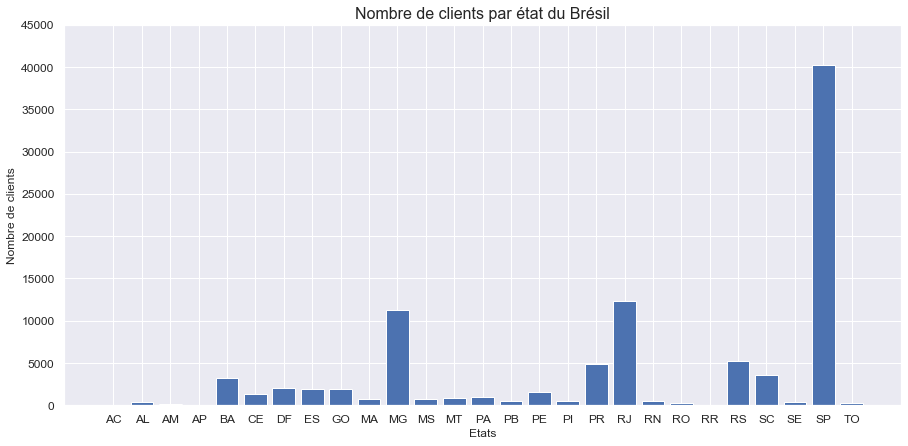

In [95]:
# Nombre de clients par état
ClientEtat = df_Cust.groupby('customer_state')['customer_unique_id'].nunique()

# Liste des états
Etats = df_Cust['customer_state'].unique()
Etats.sort()

# Répartition des clients par état
fig31 = plt.figure(figsize=(15, 7))
axes = plt.axes()
axes.set_xlabel('Etats', fontsize=12)
axes.set_ylabel('Nombre de clients', fontsize=12)
axes.set_ylim(0, 45000)
plt.title('Nombre de clients par état du Brésil', fontsize=16)
plt.bar(Etats, ClientEtat)
plt.xticks(Etats, fontsize=12)
plt.yticks(fontsize=12)

Les deux tiers des clients sont situés dans 3 états (Sao Paulo, Rio de Janeiro et Minas Gerais)

#### 3.2 - [Geo Location](#32)<a class="anchor" id="32"></a>

In [96]:
df_GeoLoc.head(3)

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.545621,-46.639292,sao paulo,SP
1,1046,-23.546081,-46.644820,sao paulo,SP
2,1046,-23.546129,-46.642951,sao paulo,SP


In [97]:
print(df_GeoLoc.shape)
cle = ['geolocation_zip_code_prefix']
df_GeoLoc[cle].drop_duplicates().shape[0] == df_GeoLoc.shape[0]

(1000163, 5)


False

Pour faire une variable distance client - vendeur. Attention Zip code à 4 chiffres sur les
zip code commencant par 0. Pas de clé unique simple ici
Feature possible : Calcul distance vendeur-clients

#### 3.3 - [Order Data set](#33)<a class="anchor" id="33"></a>

In [98]:
df_OrdDtset.head(3)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00


In [99]:
print('Nb Customer Id:', df_OrdDtset['customer_id'].nunique())
print('Nb Order Id:', df_OrdDtset['order_id'].nunique())
print('Taille:', df_OrdDtset.shape)
cle = ['customer_id']
df_OrdDtset[cle].drop_duplicates().shape[0] == df_OrdDtset.shape[0]

Nb Customer Id: 99441
Nb Order Id: 99441
Taille: (99441, 8)


True

In [100]:
# On s'assure que order_id est une variable de string
df_OrdDtset['order_id'] = df_OrdDtset['order_id'].astype('str', copy=False)

La clé unique est Customer_Id. 
Il ne manque pas de lignes dans l'un ou l'autre
Feature possible : Temps entre livraison et commande, temps entre estimation date livraison et date réélle.

(array([     0.,  20000.,  40000.,  60000.,  80000., 100000.]),
 <a list of 6 Text yticklabel objects>)

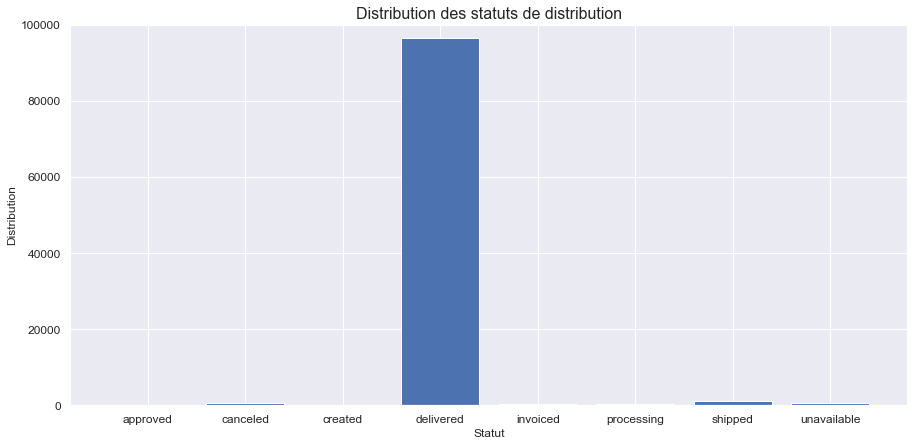

In [101]:
# Distribution des statuts
Dist_Statut = df_OrdDtset.groupby('order_status')['customer_id'].nunique()

# Liste des scores
Statut = df_OrdDtset['order_status'].unique()
Statut.sort()

# Répartition des scores
fig31 = plt.figure(figsize=(15, 7))
axes = plt.axes()
axes.set_xlabel('Statut', fontsize=12)
axes.set_ylabel('Distribution', fontsize=12)
axes.set_ylim(0, 100000)
plt.title('Distribution des statuts de distribution', fontsize=16)
plt.bar(Statut, Dist_Statut)
plt.xticks(Statut, fontsize=12)
plt.yticks(fontsize=12)

La grande majorité des commandes a été réceptionnée.

In [102]:
# On transforme au format date pour pouvoir faire des opérations de calcul.
df_OrdDtset['order_delivered_customer_date'] = pd.to_datetime(
    df_OrdDtset['order_delivered_customer_date'], yearfirst=True)
df_OrdDtset['order_purchase_timestamp'] = pd.to_datetime(
    df_OrdDtset['order_purchase_timestamp'], yearfirst=True)
df_OrdDtset['order_estimated_delivery_date'] = pd.to_datetime(
    df_OrdDtset['order_estimated_delivery_date'], yearfirst=True)

# On calcule un temps de livraison par commande.
df_OrdDtset['delivery_time'] = df_OrdDtset['order_delivered_customer_date'] - \
                               df_OrdDtset['order_purchase_timestamp']

# On calcule la précision de la livraison / estimation par commande.
df_OrdDtset['delivery_accuracy'] = \
 df_OrdDtset['order_delivered_customer_date'] - \
 df_OrdDtset['order_estimated_delivery_date']

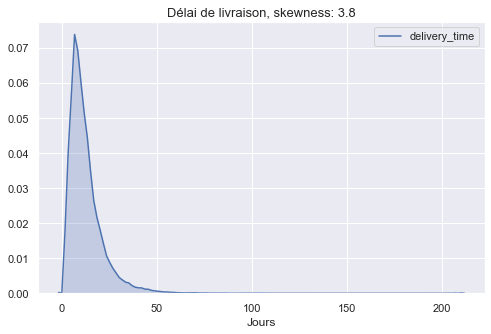

In [103]:
# Density plot délai de livraison
fig, ax = plt.subplots(figsize=(8, 5))
sns.kdeplot(df_OrdDtset['delivery_time'].dt.total_seconds()/(3600 * 24),
            shade=True, ax=ax)
ax.set_title('Délai de livraison, skewness: ' +
             str(round(df_OrdDtset['delivery_time']
                 .astype('timedelta64[D]').skew(), 1)), fontsize=13)
ax.set_xlabel('Jours', fontsize=12)
plt.show()

La majorité des commandes arrivent dans les 30 jours suivant la commande.

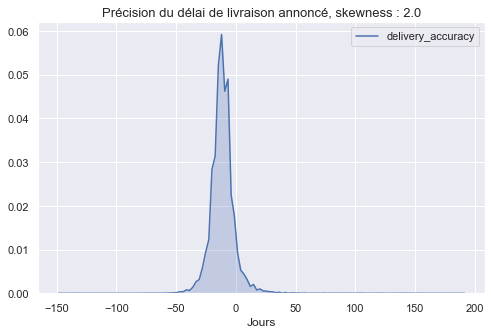

In [104]:
# Density plot précision délai livraion
fig, ax = plt.subplots(figsize=(8, 5))
sns.kdeplot(df_OrdDtset['delivery_accuracy'].dt.total_seconds() /
            (3600 * 24), shade=True, ax=ax)
ax.set_title('Précision du délai de livraison annoncé, skewness : '
             + str(round(df_OrdDtset['delivery_accuracy']
                         .astype('timedelta64[D]').skew(), 1)), fontsize=13)
ax.set_xlabel('Jours', fontsize=12)
plt.show()

La majorité des commandes ont été reçues avant la date estimée.

In [105]:
# Tri par date.
df_OrdDtset.sort_values(by="order_purchase_timestamp", ascending=True)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,delivery_time,delivery_accuracy
4541,2e7a8482f6fb09756ca50c10d7bfc047,08c5351a6aca1c1589a38f244edeee9d,shipped,2016-09-04 21:15:19,2016-10-07 13:18:03,2016-10-18 13:14:51,NaT,2016-10-20,NaT,NaT
4396,e5fa5a7210941f7d56d0208e4e071d35,683c54fc24d40ee9f8a6fc179fd9856c,canceled,2016-09-05 00:15:34,2016-10-07 13:17:15,NaN,NaT,2016-10-28,NaT,NaT
10071,809a282bbd5dbcabb6f2f724fca862ec,622e13439d6b5a0b486c435618b2679e,canceled,2016-09-13 15:24:19,2016-10-07 13:16:46,NaN,NaT,2016-09-30,NaT,NaT
30710,bfbd0f9bdef84302105ad712db648a6c,86dc2ffce2dfff336de2f386a786e574,delivered,2016-09-15 12:16:38,2016-09-15 12:16:38,2016-11-07 17:11:53,2016-11-09 07:47:38,2016-10-04,54 days 19:31:00,36 days 07:47:38
83078,71303d7e93b399f5bcd537d124c0bcfa,b106b360fe2ef8849fbbd056f777b4d5,canceled,2016-10-02 22:07:52,2016-10-06 15:50:56,NaN,NaT,2016-10-25,NaT,NaT
...,...,...,...,...,...,...,...,...,...,...
50387,392ed9afd714e3c74767d0c4d3e3f477,2823ffda607a2316375088e0d00005ec,canceled,2018-09-29 09:13:03,NaN,NaN,NaT,2018-10-15,NaT,NaT
88500,616fa7d4871b87832197b2a137a115d2,bf6181a85bbb4115736c0a8db1a53be3,canceled,2018-10-01 15:30:09,NaN,NaN,NaT,2018-10-23,NaT,NaT
31891,a2ac6dad85cf8af5b0afb510a240fe8c,4c2ec60c29d10c34bd49cb88aa85cfc4,canceled,2018-10-03 18:55:29,NaN,NaN,NaT,2018-10-16,NaT,NaT
68373,b059ee4de278302d550a3035c4cdb740,856336203359aa6a61bf3826f7d84c49,canceled,2018-10-16 20:16:02,NaN,NaN,NaT,2018-11-12,NaT,NaT


In [106]:
print('Orders from {} to {}'.format(
    df_OrdDtset['order_purchase_timestamp'].min(),
    df_OrdDtset['order_purchase_timestamp'].max()))

Orders from 2016-09-04 21:15:19 to 2018-10-17 17:30:18


In [107]:
# On enlève hh:mm:ss de la date et on calcule le nb de commande par jour.
df_OrdDtset["order_purchase_date"] = \
    df_OrdDtset["order_purchase_timestamp"].dt.date
Order_day = df_OrdDtset.groupby('order_purchase_date')['customer_id'].nunique()
Period = df_OrdDtset['order_purchase_date'].unique()
Period.sort()

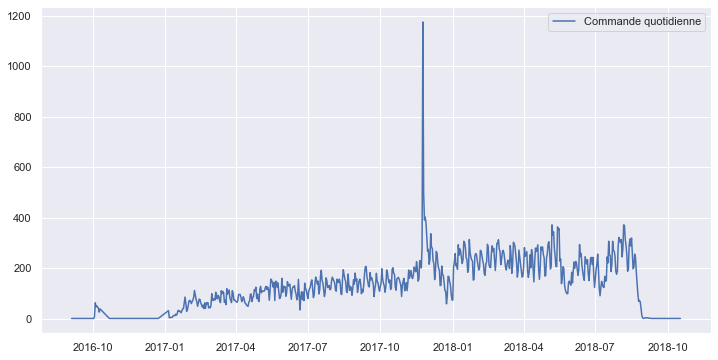

In [108]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(Period, Order_day, label="Commande quotidienne")
ax.legend()
plt.show()

Nous avons des commandes du 4 septembre 2016 au  17 octobre 2018.

In [109]:
# On garde uniquement les commandes qui ont été livrées.
# des commandes passé en 2016 n'ont pas été livrées
Delta1 = df_OrdDtset.shape[0]
print('Taille avant filtre: ',df_OrdDtset.shape)
Delivered_Order = df_OrdDtset['order_status'] == 'delivered'
df_OrdDtset = df_OrdDtset[Delivered_Order]
Delta2 = df_OrdDtset.shape[0]
print('Commande supprimée :', Delta2 - Delta1)
df_OrdDtset.sort_values(by="order_purchase_timestamp", ascending=True)

Taille avant filtre:  (99441, 11)
Commande supprimée : -2963


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,delivery_time,delivery_accuracy,order_purchase_date
30710,bfbd0f9bdef84302105ad712db648a6c,86dc2ffce2dfff336de2f386a786e574,delivered,2016-09-15 12:16:38,2016-09-15 12:16:38,2016-11-07 17:11:53,2016-11-09 07:47:38,2016-10-04,54 days 19:31:00,36 days 07:47:38,2016-09-15
93285,3b697a20d9e427646d92567910af6d57,355077684019f7f60a031656bd7262b8,delivered,2016-10-03 09:44:50,2016-10-06 15:50:54,2016-10-23 14:02:13,2016-10-26 14:02:13,2016-10-27,23 days 04:17:23,-1 days +14:02:13,2016-10-03
28424,be5bc2f0da14d8071e2d45451ad119d9,7ec40b22510fdbea1b08921dd39e63d8,delivered,2016-10-03 16:56:50,2016-10-06 16:03:44,2016-10-21 16:33:46,2016-10-27 18:19:38,2016-11-07,24 days 01:22:48,-11 days +18:19:38,2016-10-03
97979,a41c8759fbe7aab36ea07e038b2d4465,6f989332712d3222b6571b1cf5b835ce,delivered,2016-10-03 21:13:36,2016-10-05 03:11:49,2016-10-25 11:57:59,2016-11-03 10:58:07,2016-11-29,30 days 13:44:31,-26 days +10:58:07,2016-10-03
88472,d207cc272675637bfed0062edffd0818,b8cf418e97ae795672d326288dfab7a7,delivered,2016-10-03 22:06:03,2016-10-04 10:28:07,2016-10-21 14:23:37,2016-10-31 11:07:42,2016-11-23,27 days 13:01:39,-23 days +11:07:42,2016-10-03
...,...,...,...,...,...,...,...,...,...,...,...
99369,52018484704db3661b98ce838612b507,e450a297a7bc6839ceb0cf1a2377fa02,delivered,2018-08-29 12:25:59,2018-08-29 12:35:17,2018-08-29 13:38:00,2018-08-30 22:48:27,2018-09-03,1 days 10:22:28,-4 days +22:48:27,2018-08-29
30077,0b223d92c27432930dfe407c6aea3041,e60df9449653a95af4549bbfcb18a6eb,delivered,2018-08-29 14:18:23,2018-08-29 14:31:07,2018-08-29 15:29:00,2018-08-30 16:24:55,2018-09-04,1 days 02:06:32,-5 days +16:24:55,2018-08-29
31486,168626408cb32af0ffaf76711caae1dc,6e353700bc7bcdf6ebc15d6de16d7002,delivered,2018-08-29 14:18:28,2018-08-29 14:30:23,2018-08-29 18:51:00,2018-08-30 16:52:31,2018-09-11,1 days 02:34:03,-12 days +16:52:31,2018-08-29
69678,03ef5dedbe7492bdae72eec50764c43f,496630b6740bcca28fce9ba50d8a26ef,delivered,2018-08-29 14:52:00,2018-08-29 15:05:22,2018-08-29 20:01:00,2018-08-30 16:36:59,2018-09-03,1 days 01:44:59,-4 days +16:36:59,2018-08-29


In [110]:
# Filtre sur période. On garde les deux années 2017 et 2018 jusqu'à fin août.
Purchase_date = (df_OrdDtset["order_purchase_date"] > date(2016, 12, 31)) & \
                 (df_OrdDtset["order_purchase_date"] < date(2018, 9, 1))
df_OrdDtset = df_OrdDtset[Purchase_date]
Delta3 = df_OrdDtset.shape[0]
print('commande supprimée :', Delta3 - Delta2,
      '\nTaille finale: ', df_OrdDtset.shape)

commande supprimée : -267 
Taille finale:  (96211, 11)


In [111]:
# On calcule la récence du dernier achat.
from datetime import timedelta
NOW = df_OrdDtset["order_purchase_date"].max() + timedelta(days=1)
df_OrdDtset['DaysSinceOrder'] = df_OrdDtset["order_purchase_date"].apply(
                                 lambda x: (NOW - x).days)

#### 3.4 - [Order Reviews Data set](#34)<a class="anchor" id="34"></a>

In [112]:
df_OrdRvews.head(3)

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24


In [113]:
print('Nb Order Id:', df_OrdRvews['order_id'].nunique())
print('Nb Review Id:', df_OrdRvews['review_id'].nunique())
print('Taille:', df_OrdRvews.shape)
cle = ['order_id']
df_OrdRvews[cle].drop_duplicates().shape[0] == df_OrdRvews.shape[0]

Nb Order Id: 99441
Nb Review Id: 99173
Taille: (100000, 7)


False

In [114]:
# On transforme en string.
df_OrdRvews['order_id'] = df_OrdRvews['order_id'].astype('str', copy=False)

In [115]:
df_OrdRvews['order_id'].value_counts()

03c939fd7fd3b38f8485a0f95798f1f6    3
df56136b8031ecd28e200bb18e6ddb2e    3
8e17072ec97ce29f0e1f111e598b0c85    3
c88b1d1b157a9999ce368f218a407141    3
c86cd0844d36479f7e7adb1edd5e59d3    2
                                   ..
f909a30204df41fa3c27e9490f536aa8    1
9aad6dbdcca5469f24d0ae9abf0977e9    1
04da4dc0ed95cc93f9f25375fa08ad47    1
3d6809371021cc510de4743748a1c235    1
7b324b5737fa42a7fb6df7c3769c3c9f    1
Name: order_id, Length: 99441, dtype: int64

La clé unique n'est pas order_id. Il existe plusieurs lignes avec le même order_id. il ne manque pas de commande.
Feature : Review score

(array([    0., 10000., 20000., 30000., 40000., 50000., 60000.]),
 <a list of 7 Text yticklabel objects>)

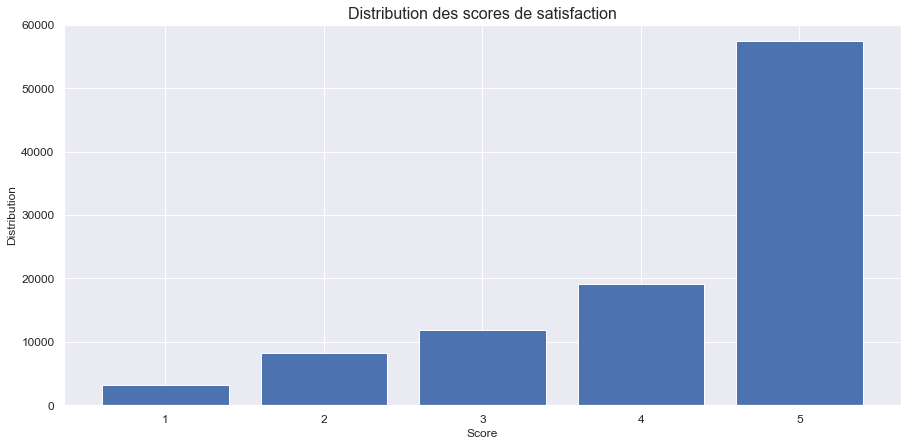

In [116]:
# Distribution des scores
Dist_Score = df_OrdRvews['review_score'].value_counts()

# Liste des scores
Score = df_OrdRvews['review_score'].unique()
Score = sorted(Score, reverse=True)

# Répartition des scores
fig31 = plt.figure(figsize=(15, 7))
axes = plt.axes()
axes.set_xlabel('Score', fontsize=12)
axes.set_ylabel('Distribution', fontsize=12)
axes.set_ylim(0, 60000)
plt.title('Distribution des scores de satisfaction', fontsize=16)
plt.bar(Score, Dist_Score)
plt.xticks(Score, fontsize=12)
plt.yticks(fontsize=12)

In [117]:
# On garde la moyenne des scores par commande.
rev_score_mean = df_OrdRvews.groupby('order_id')['review_score'].mean()
df_OrdRvews['review_score'] = df_OrdPaymt['order_id'].map(rev_score_mean)
df_OrdRvews.drop_duplicates(subset=['order_id'], keep='last', inplace=True)
df_OrdRvews

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,1.0,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5.0,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5.0,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5.0,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5.0,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53
...,...,...,...,...,...,...,...
99995,f3897127253a9592a73be9bdfdf4ed7a,22ec9f0669f784db00fa86d035cf8602,5.0,NaN,NaN,2017-12-09 00:00:00,2017-12-11 20:06:42
99996,b3de70c89b1510c4cd3d0649fd302472,55d4004744368f5571d1f590031933e4,5.0,NaN,"Excelente mochila, entrega super rápida. Super...",2018-03-22 00:00:00,2018-03-23 09:10:43
99997,1adeb9d84d72fe4e337617733eb85149,7725825d039fc1f0ceb7635e3f7d9206,5.0,NaN,NaN,2018-07-01 00:00:00,2018-07-02 12:59:13
99998,be360f18f5df1e0541061c87021e6d93,f8bd3f2000c28c5342fedeb5e50f2e75,5.0,NaN,Solicitei a compra de uma capa de retrovisor c...,2017-12-15 00:00:00,2017-12-16 01:29:43


#### 3.5 - [Order Payments Data set](#35)<a class="anchor" id="35"></a>

In [118]:
df_OrdPaymt.head(10)

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45
5,298fcdf1f73eb413e4d26d01b25bc1cd,1,credit_card,2,96.12
6,771ee386b001f06208a7419e4fc1bbd7,1,credit_card,1,81.16
7,3d7239c394a212faae122962df514ac7,1,credit_card,3,51.84
8,1f78449c87a54faf9e96e88ba1491fa9,1,credit_card,6,341.09
9,0573b5e23cbd798006520e1d5b4c6714,1,boleto,1,51.95


In [119]:
print('Nb Order Id:', df_OrdPaymt['order_id'].nunique())
print('Taille:', df_OrdPaymt.shape)
cle = ['order_id', 'payment_sequential']
df_OrdPaymt[cle].drop_duplicates().shape[0] == df_OrdPaymt.shape[0]

Nb Order Id: 99440
Taille: (103886, 5)


True

In [120]:
print(df_OrdPaymt['payment_sequential'].unique(), '\n',
      df_OrdPaymt['payment_type'].unique(), '\n',
      df_OrdPaymt['payment_installments'].unique())

[ 1  2  4  5  3  8  6  7 10 11 17 19 27 12  9 15 13 14 16 25 22 26 29 28
 18 21 24 23 20] 
 ['credit_card' 'boleto' 'voucher' 'debit_card' 'not_defined'] 
 [ 8  1  2  3  6  5  4 10  7 12  9 13 15 24 11 18 14 20 21 17 22  0 16 23]


In [121]:
# On s'assure que order_id est une variable de string
df_OrdPaymt['order_id'] = df_OrdPaymt['order_id'].astype('str', copy=False)

In [122]:
# On calcule le nombre de paiement par commande
paymt_sq_nb = df_OrdPaymt.groupby('order_id')['payment_sequential'].count()
df_OrdPaymt['Pymt_Sq_Nb'] = df_OrdPaymt['order_id'].map(paymt_sq_nb)
df_OrdPaymt[df_OrdPaymt['Pymt_Sq_Nb'] > 1]

,order_id,payment_sequential,payment_type,payment_installments,payment_value,Pymt_Sq_Nb
25,5cfd514482e22bc992e7693f0e3e8df7,2,voucher,1,45.17,2
35,b2bb080b6bc860118a246fd9b6fad6da,1,credit_card,1,173.84,2
75,3689194c14ad4e2e7361ebd1df0e77b0,2,voucher,1,57.53,2
84,723e462ce1ee50e024887c0b403130f3,1,credit_card,1,13.80,2
102,21b8b46679ea6482cbf911d960490048,2,voucher,1,43.12,2
...,...,...,...,...,...,...
103778,fd86c80924b4be8fb7f58c4ecc680dae,1,credit_card,1,76.10,3
103817,6d4616de4341417e17978fe57aec1c46,1,credit_card,1,19.18,2
103860,31bc09fdbd701a7a4f9b55b5955b8687,6,voucher,1,77.99,7
103869,c9b01bef18eb84888f0fd071b8413b38,1,credit_card,6,238.16,2


In [123]:
# On crée une variable pour chaque type de paiement par commande
df_OrdPaymt['order_and_payment'] = df_OrdPaymt['order_id'] + \
                                    df_OrdPaymt['payment_type']
# On calcule la somme par type de paiement par commande
paymt_tp_amounnt = df_OrdPaymt.groupby('order_and_payment')['payment_value']\
                    .sum()
df_OrdPaymt['Type_Paid'] = df_OrdPaymt['order_and_payment']\
                            .map(paymt_tp_amounnt)

In [124]:
# On crée un data frame pour avoir la somme par type de paiement par commande
df_temp2 = df_OrdPaymt[['order_id', 'payment_type',
                        'order_and_payment', 'Type_Paid']]

In [125]:
df_temp2.drop_duplicates(subset=['order_and_payment'],
                         keep='last', inplace=True)

C:\anaconda\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [126]:
# On crée un data frame ou a la somme par type de paiement par commande 
# (plusieurs types possibles par commande)
df_OrdPaymt2 = df_temp2.pivot(index = 'order_id', columns = 'payment_type', values = 'Type_Paid')
df_OrdPaymt2.fillna(0, inplace=True)
df_OrdPaymt2.head(100)

payment_type,boleto,credit_card,debit_card,not_defined,voucher
order_id,,,,,
00010242fe8c5a6d1ba2dd792cb16214,0.00,72.19,0.00,0.0,0.00
00018f77f2f0320c557190d7a144bdd3,0.00,259.83,0.00,0.0,0.00
000229ec398224ef6ca0657da4fc703e,0.00,216.87,0.00,0.0,0.00
00024acbcdf0a6daa1e931b038114c75,0.00,25.78,0.00,0.0,0.00
00042b26cf59d7ce69dfabb4e55b4fd9,0.00,218.04,0.00,0.0,0.00
00048cc3ae777c65dbb7d2a0634bc1ea,34.59,0.00,0.00,0.0,0.00
00054e8431b9d7675808bcb819fb4a32,0.00,31.75,0.00,0.0,0.00
000576fe39319847cbb9d288c5617fa6,0.00,880.75,0.00,0.0,0.00
0005a1a1728c9d785b8e2b08b904576c,0.00,157.60,0.00,0.0,0.00


In [127]:
df_OrdPaymt2.shape

(99440, 5)

In [128]:
# On garde une ligne par commande
df_OrdPaymt.drop_duplicates(subset=['order_id'], keep='last', inplace=True)
df_OrdPaymt

,order_id,payment_sequential,payment_type,payment_installments,payment_value,Pymt_Sq_Nb,order_and_payment,Type_Paid
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33,1,b81ef226f3fe1789b1e8b2acac839d17credit_card,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39,1,a9810da82917af2d9aefd1278f1dcfa0credit_card,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71,1,25e8ea4e93396b6fa0d3dd708e76c1bdcredit_card,65.71
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78,1,ba78997921bbcdc1373bb41e913ab953credit_card,107.78
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45,1,42fdf880ba16b47b59251dd489d4441acredit_card,128.45
...,...,...,...,...,...,...,...,...
103881,0406037ad97740d563a178ecc7a2075c,1,boleto,1,363.31,1,0406037ad97740d563a178ecc7a2075cboleto,363.31
103882,7b905861d7c825891d6347454ea7863f,1,credit_card,2,96.80,1,7b905861d7c825891d6347454ea7863fcredit_card,96.80
103883,32609bbb3dd69b3c066a6860554a77bf,1,credit_card,1,47.77,1,32609bbb3dd69b3c066a6860554a77bfcredit_card,47.77
103884,b8b61059626efa996a60be9bb9320e10,1,credit_card,5,369.54,1,b8b61059626efa996a60be9bb9320e10credit_card,369.54


In [129]:
# On fusionne les 2 df.
df_OrdPaymt3 = pd.merge(df_OrdPaymt, df_OrdPaymt2,
                        left_on='order_id', right_index=True)
df_OrdPaymt3.shape

(99440, 13)

Attention il manque une commande dans ce data set. De plus, il y a plusieurs lignes pur une même commande.
Feature possible : type de paiement, panier commande

#### 3.6 - [Products Data set](#36)<a class="anchor" id="36"></a>

In [130]:
df_PdctDtset.head(3)

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0


In [131]:
print('Product Id:', df_PdctDtset['product_id'].nunique(), '\n',
      'Nombre de catégorie :',
      df_PdctDtset['product_category_name'].nunique(),)
print('Taille:', df_PdctDtset.shape)
cle = ['product_id']
df_PdctDtset[cle].drop_duplicates().shape[0] == df_PdctDtset.shape[0]

Product Id: 32951 
 Nombre de catégorie : 73
Taille: (32951, 9)


True

On a le même nombre de Product ID entre Product DS et Order Item DS.
Les features Product_description_lenght et product_photos_qty peuvent etre intéressante

In [132]:
# Différence de catégorie entre Data set
set(df_PdctDtset['product_category_name'])\
    .symmetric_difference(df_PdctCat['product_category_name'])

{nan, 'pc_gamer', 'portateis_cozinha_e_preparadores_de_alimentos'}

In [133]:
# On crée les catégories non traduite
df_PdctCat.loc[71] = ['pc_gamer', 'computers']
df_PdctCat.loc[72] = ['portateis_cozinha_e_preparadores_de_alimentos', 'home_appliances']
df_PdctCat.loc[73] = ['other','other']
df_PdctCat.head(74)

,product_category_name,product_category_name_english
0,beleza_saude,health_beauty
1,informatica_acessorios,computers_accessories
2,automotivo,auto
3,cama_mesa_banho,bed_bath_table
4,moveis_decoracao,furniture_decor
5,esporte_lazer,sports_leisure
6,perfumaria,perfumery
7,utilidades_domesticas,housewares
8,telefonia,telephony
9,relogios_presentes,watches_gifts


In [134]:
# On remplit les Na.
df_PdctDtset['product_category_name'].fillna("other", inplace=True)
df_PdctDtset['product_name_lenght'].fillna(0, inplace=True)
df_PdctDtset['product_description_lenght'].fillna(0, inplace=True)
df_PdctDtset['product_photos_qty'].fillna(0, inplace=True)

In [135]:
# Dictionnaire pour réduire le nombre de catégorie
product_categories_dict = {
    'construction_tools_construction': 'construction',
    'construction_tools_lights': 'construction',
    'construction_tools_safety': 'construction',
    'costruction_tools_garden': 'construction',
    'costruction_tools_tools': 'construction',
    'garden_tools': 'construction',
    'home_construction': 'construction',

    'fashio_female_clothing': 'fashion',
    'fashion_bags_accessories': 'fashion',
    'fashion_childrens_clothes': 'fashion',
    'fashion_male_clothing': 'fashion',
    'fashion_shoes': 'fashion',
    'fashion_sport': 'fashion',
    'fashion_underwear_beach': 'fashion',
    'health_beauty': 'fashion',
    'perfumery': 'fashion',
    'diapers_and_hygiene': 'fashion',
    'baby': 'fashion',
    'luggage_accessories': 'fashion',

    'furniture_bedroom': 'home',
    'furniture_decor': 'home',
    'furniture_living_room': 'home',
    'furniture_mattress_and_upholstery': 'home',
    'bed_bath_table': 'home',
    'kitchen_dining_laundry_garden_furniture': 'home',
    'office_furniture': 'home',
    'home_appliances': 'home',
    'home_appliances_2': 'home',
    'home_comfort_2': 'home',
    'home_confort': 'home',
    'air_conditioning': 'home',
    'housewares': 'home',
    'art': 'home',
    'arts_and_craftmanship': 'home',
    'flowers': 'home',
    'cool_stuff': 'home',

    'drinks': 'food',
    'food': 'food',
    'food_drink': 'food',
    'la_cuisine': 'food',

    'electronics': 'electronics',
    'audio': 'electronics',
    'tablets_printing_image': 'electronics',
    'telephony': 'electronics',
    'fixed_telephony': 'electronics',
    'small_appliances': 'electronics',
    'small_appliances_home_oven_and_coffee': 'electronics',
    'computers_accessories': 'electronics',
    'computers': 'electronics',

    'sports_leisure': 'leisure',
    'consoles_games': 'leisure',
    'musical_instruments': 'leisure',
    'toys': 'leisure',
    'cine_photo': 'leisure',
    'dvds_blu_ray': 'leisure',
    'cds_dvds_musicals': 'leisure',
    'music': 'leisure',
    'books_general_interest': 'leisure',
    'books_imported': 'leisure',
    'books_technical': 'leisure',

    'christmas_supplies': 'misc',
    'stationery': 'misc',
    'party_supplies': 'misc',
    'auto': 'misc',
    'watches_gifts': 'misc',
    'agro_industry_and_commerce': 'misc',
    'industry_commerce_and_business': 'misc',
    'security_and_services': 'misc',
    'signaling_and_security': 'misc',
    'market_place': 'misc',
    'pet_shop': 'misc',
    'other': 'misc'
}

In [136]:
cat_ser = pd.Series(product_categories_dict) 
df_PdctCat['cat'] = df_PdctCat['product_category_name_english'].map(cat_ser)
df_PdctCat

,product_category_name,product_category_name_english,cat
0,beleza_saude,health_beauty,fashion
1,informatica_acessorios,computers_accessories,electronics
2,automotivo,auto,misc
3,cama_mesa_banho,bed_bath_table,home
4,moveis_decoracao,furniture_decor,home
5,esporte_lazer,sports_leisure,leisure
6,perfumaria,perfumery,fashion
7,utilidades_domesticas,housewares,home
8,telefonia,telephony,electronics
9,relogios_presentes,watches_gifts,misc


In [137]:
# On fusionne pour avoir les catégories par produit.
df_cat = pd.merge(df_PdctCat, df_PdctDtset, on='product_category_name')
# On supprime des variables non pertinentes
df_cat.drop(['product_category_name', 'product_category_name_english',
             'product_weight_g', 'product_length_cm',
             'product_height_cm', 'product_width_cm'],
            axis='columns', inplace=True)
df_cat

,cat,product_id,product_name_lenght,product_description_lenght,product_photos_qty
0,fashion,e3e020af31d4d89d2602272b315c3f6e,58.0,1987.0,3.0
1,fashion,c5d8079278e912d7e3b6beb48ecb56e8,60.0,330.0,1.0
2,fashion,36555a2f528d7b2a255c504191445d39,51.0,1069.0,1.0
3,fashion,e586ebb6022265ae1eea38f46ffe3ead,40.0,1469.0,3.0
4,fashion,75b4372e69a42f8ae1d908c076f547b2,22.0,1313.0,1.0
...,...,...,...,...,...
32946,misc,b0a0c5dd78e644373b199380612c350a,0.0,0.0,0.0
32947,misc,10dbe0fbaa2c505123c17fdc34a63c56,0.0,0.0,0.0
32948,misc,bd2ada37b58ae94cc838b9c0569fecd8,0.0,0.0,0.0
32949,misc,fa51e914046aab32764c41356b9d4ea4,0.0,0.0,0.0


#### 3.7 - [Order Items Data set](#37)<a class="anchor" id="37"></a>

In [138]:
df_OrdItem.head(3)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.9,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.0,17.87


In [139]:
# Description
print('Nb Order Id:', df_OrdItem['order_id'].nunique(), '\n',
      'Nb Product Id:', df_OrdItem['product_id'].nunique(), '\n',
      'Nb Seller Id:', df_OrdItem['seller_id'].nunique())
print('Taille:', df_OrdItem.shape)
cle = ['order_id', 'order_item_id']
df_OrdItem[cle].drop_duplicates().shape[0] == df_OrdItem.shape[0]

Nb Order Id: 98666 
 Nb Product Id: 32951 
 Nb Seller Id: 3095
Taille: (112650, 7)


True

In [140]:
# On calcule la somme de l'article et des frais de port par ligne
df_OrdItem['Total_Price_Item'] = df_OrdItem['price'] +\
                                df_OrdItem['freight_value']

In [141]:
# On calcule le nombre d'article par commande
s = df_OrdItem.groupby('order_id')['order_item_id'].count()
df_OrdItem['Item_Qty'] = df_OrdItem['order_id'].map(s)
# On calcule le cout total de la commande
s2 = df_OrdItem.groupby('order_id')['Total_Price_Item'].sum()
df_OrdItem['Total_Price_Order'] = df_OrdItem['order_id'].map(s2)

In [142]:
# On merge avec df_cat pour avoir le prix par catégorie par commande
df_OrdItem2 = pd.merge(df_OrdItem, df_cat, on='product_id')
df_OrdItem2.head(2)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,Total_Price_Item,Item_Qty,Total_Price_Order,cat,product_name_lenght,product_description_lenght,product_photos_qty
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29,72.19,1,72.19,home,58.0,598.0,4.0
1,130898c0987d1801452a8ed92a670612,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-07-05 02:44:11,55.9,17.96,73.86,1,73.86,home,58.0,598.0,4.0


In [143]:
df_OrdItem2.shape

(112650, 14)

In [144]:
# On crée une variable pour chaque catégorie de produit par commande
df_OrdItem2['order_and_cat'] = df_OrdItem2['order_id'] + df_OrdItem2['cat']
# On calcule la somme par catégorie par commande
cat_amounnt = df_OrdItem2.groupby('order_and_cat')['Total_Price_Item'].sum()
df_OrdItem2['Cat_Paid'] = df_OrdItem2['order_and_cat'].map(cat_amounnt)
# On crée un df pour avoir la somme par catégorie de produit par commande
df_temp_it = df_OrdItem2[['order_id', 'cat', 'order_and_cat', 'Cat_Paid']]
df_temp_it.drop_duplicates(subset=['order_and_cat'], keep='last', inplace=True)

df_OrdItem3 = df_temp_it.pivot(index='order_id', columns='cat',
                               values='Cat_Paid')
df_OrdItem3.fillna(0, inplace=True)
df_OrdItem3.shape

C:\anaconda\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


(98666, 7)

In [145]:
# On garde une ligne par commande
df_OrdItem2.drop_duplicates(subset=['order_id'], keep='last', inplace=True)

In [146]:
# On merge nos df.
df_OrdItem4 = pd.merge(df_OrdItem2, df_OrdItem3,
                       left_on='order_id', right_index=True)
df_OrdItem4.shape

(98666, 23)

In [147]:
# Moyenne du nb d'article dans les commandes avec 2 ou plus
tmp_ord = df_OrdItem4[df_OrdItem4['Item_Qty'] > 1]
print(tmp_ord['Item_Qty'].mean(), tmp_ord.shape)

2.4265020911965727 (9803, 23)


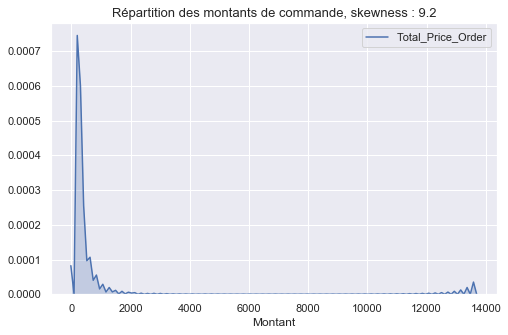

In [148]:
# Density plot montant total de commande
fig, ax = plt.subplots(figsize=(8, 5))
sns.kdeplot(df_OrdItem4['Total_Price_Order'], shade=True, ax=ax)
ax.set_title('Répartition des montants de commande, skewness : '
             + str(round(df_OrdItem4['Total_Price_Order'].skew(), 1)),
             fontsize=13)
ax.set_xlabel('Montant', fontsize=12)
plt.show()

Il manque presque 1000 commandes dans ce data set
Il peut y avoir plusieurs produits/items par commande
Feature possible: nombre de produits par commande, prix produit, frais de port, prix par catégorie.

#### 3.8 - [Sellers Data set](#38)<a class="anchor" id="38"></a>

In [149]:
df_SelrsDtset.head(3)

,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP
2,ce3ad9de960102d0677a81f5d0bb7b2d,20031,rio de janeiro,RJ


In [150]:
print('nb Seller Id:', df_SelrsDtset['seller_id'].nunique(), '\n')
print('Taille:', df_SelrsDtset.shape)
cle = ['seller_id']
df_SelrsDtset[cle].drop_duplicates().shape[0] == df_SelrsDtset.shape[0]

nb Seller Id: 3095 

Taille: (3095, 4)


True

Il y a le même nombre de seller_id ( 3095). Cle unique seller_id

### 4 - [Consolidation du data set](#4)<a class="anchor" id="4"></a>

In [151]:
# Fusion de customer et order
df = pd.merge(df_Cust, df_OrdDtset, on='customer_id')
# On supprime des variables non pertinentes
df.drop(['order_approved_at', 'order_delivered_carrier_date',
        'order_delivered_customer_date', 'order_estimated_delivery_date',
         'customer_zip_code_prefix', 'customer_city',
         'order_purchase_timestamp'],
        axis='columns', inplace=True)
df

,customer_id,customer_unique_id,customer_state,order_id,order_status,delivery_time,delivery_accuracy,order_purchase_date,DaysSinceOrder
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,8 days 19:30:00,-11 days +10:35:35,2017-05-16,471
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,SP,29150127e6685892b6eab3eec79f59c7,delivered,16 days 15:52:55,-8 days +12:41:19,2018-01-12,230
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,26 days 01:51:06,1 days 17:58:51,2018-05-19,103
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,SP,951670f92359f4fe4a63112aa7306eba,delivered,14 days 23:57:47,-13 days +16:04:25,2018-03-13,170
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,11 days 11:04:18,-6 days +20:55:48,2018-07-29,32
...,...,...,...,...,...,...,...,...,...
96206,17ddf5dd5d51696bb3d7c6291687be6f,1a29b476fee25c95fbafc67c5ac95cf8,SP,6760e20addcf0121e9d58f2f1ff14298,delivered,6 days 04:18:20,-12 days +20:06:37,2018-04-07,145
96207,e7b71a9017aa05c9a7fd292d714858e8,d52a67c98be1cf6a5c84435bd38d095d,SP,9ec0c8947d973db4f4e8dcf1fbfa8f1b,delivered,7 days 10:34:23,-9 days +18:54:45,2018-04-04,148
96208,5e28dfe12db7fb50a4b2f691faecea5e,e9f50caf99f032f0bf3c55141f019d99,CE,fed4434add09a6f332ea398efd656a5c,delivered,30 days 22:51:25,7 days 19:03:15,2018-04-08,144
96209,56b18e2166679b8a959d72dd06da27f9,73c2643a0a458b49f58cea58833b192e,RS,e31ec91cea1ecf97797787471f98a8c2,delivered,12 days 22:50:06,-19 days +19:58:39,2017-11-03,300


In [152]:
df1 = pd.merge(df, df_OrdRvews, on='order_id')
df1.drop(['review_comment_title', 'review_comment_message',
          'review_creation_date', 'review_answer_timestamp',
          'review_id'], axis='columns', inplace=True)
df1.shape

(96211, 10)

In [153]:
df2 = pd.merge(df1, df_OrdPaymt3, on='order_id')
df2.drop(['payment_type', 'payment_installments', 'payment_value',
         'payment_sequential'], axis='columns', inplace=True)
df2.shape

(96211, 18)

In [154]:
df3 = pd.merge(df2, df_OrdItem4, on='order_id')
df3.drop(['order_item_id', 'shipping_limit_date',
         'price', 'freight_value'], axis='columns', inplace=True)
df3.shape

(96211, 36)

In [155]:
df5 = pd.merge(df3, df_SelrsDtset, on='seller_id')
df5.drop(['seller_zip_code_prefix', 'seller_city',
         'seller_state'], axis='columns', inplace=True)

In [156]:
var_input_to_le = ['customer_state']

# Label encoder pour connaître l'état de chaque client
le = preprocessing.LabelEncoder()
df5['State_Customer'] = le.fit_transform(df.loc[:, 'customer_state'])
df5

,customer_id,customer_unique_id,customer_state,order_id,order_status,delivery_time,delivery_accuracy,order_purchase_date,DaysSinceOrder,review_score,Pymt_Sq_Nb,order_and_payment,Type_Paid,boleto,credit_card,debit_card,not_defined,voucher,product_id,seller_id,Total_Price_Item,Item_Qty,Total_Price_Order,cat,product_name_lenght,product_description_lenght,product_photos_qty,order_and_cat,Cat_Paid,construction,electronics,fashion,food,home,leisure,misc,State_Customer
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,8 days 19:30:00,-11 days +10:35:35,2017-05-16,471,5.0,1,00e7ee1b050b8499577073aeb2a297a1credit_card,146.87,0.00,146.87,0.0,0.0,0.0,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,146.87,1,146.87,home,41.0,1141.0,1.0,00e7ee1b050b8499577073aeb2a297a1home,146.87,0.00,0.00,0.00,0.00,146.87,0.0,0.00,25
1,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,26 days 01:51:06,1 days 17:58:51,2018-05-19,103,4.0,1,b2059ed67ce144a36e2aa97d2c9e9ad2credit_card,157.73,0.00,157.73,0.0,0.0,0.0,bd07b66896d6f1494f5b86251848ced7,7c67e1448b00f6e969d365cea6b010ab,157.73,1,157.73,home,55.0,955.0,1.0,b2059ed67ce144a36e2aa97d2c9e9ad2home,157.73,0.00,0.00,0.00,0.00,157.73,0.0,0.00,25
2,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,SP,951670f92359f4fe4a63112aa7306eba,delivered,14 days 23:57:47,-13 days +16:04:25,2018-03-13,170,5.0,1,951670f92359f4fe4a63112aa7306ebacredit_card,173.30,0.00,173.30,0.0,0.0,0.0,a5647c44af977b148e0a3a4751a09e2e,7c67e1448b00f6e969d365cea6b010ab,173.30,1,173.30,home,48.0,1066.0,1.0,951670f92359f4fe4a63112aa7306ebahome,173.30,0.00,0.00,0.00,0.00,173.30,0.0,0.00,25
3,4c06b42fbf7b97ab10779cda5549cd1c,07d190f123147d9e89d4b922543d7948,MA,997fd4b37386d10b57d4ac8cdec011a6,delivered,31 days 09:43:34,-8 days +19:42:53,2018-07-08,53,5.0,1,997fd4b37386d10b57d4ac8cdec011a6credit_card,315.75,0.00,315.75,0.0,0.0,0.0,8ed094bfe076c568f6bb10feada3f75d,7c67e1448b00f6e969d365cea6b010ab,315.75,1,315.75,home,43.0,1128.0,1.0,997fd4b37386d10b57d4ac8cdec011a6home,315.75,0.00,0.00,0.00,0.00,315.75,0.0,0.00,25
4,8276de07ef25225d412b8462d73f8664,332cf4e83e16004ba7dca932ce82475b,RS,b63fff1ef8b6201df68bb611ee41129e,delivered,29 days 15:37:58,-6 days +13:53:25,2017-04-02,515,5.0,1,b63fff1ef8b6201df68bb611ee41129eboleto,146.21,146.21,0.00,0.0,0.0,0.0,aba86c093ccdbac75b09111d57e50004,7c67e1448b00f6e969d365cea6b010ab,146.21,1,146.21,home,41.0,154.0,1.0,b63fff1ef8b6201df68bb611ee41129ehome,146.21,0.00,0.00,0.00,0.00,146.21,0.0,0.00,25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96206,502e8addaeba926b9c154da9f3bbbecf,38e482d7770a43f5929378c4dec76d5e,RN,f80896ddec0878ff2475719a8784d53c,delivered,12 days 07:05:58,-27 days +22:08:29,2018-08-16,14,4.0,1,f80896ddec0878ff2475719a8784d53ccredit_card,1789.02,0.00,1789.02,0.0,0.0,0.0,c7b8e643fca22f6d8ec5f4b76b72e65f,cb810bd318f51b3dc3c753944d61a1fa,1789.02,1,1789.02,fashion,45.0,723.0,1.0,f80896ddec0878ff2475719a8784d53cfashion,1789.02,0.00,0.00,1789.02,0.00,0.00,0.0,0.00,25
96207,59168d27c5da6a50e3d1f03d482e80b2,393c2ace23a135d0bcc7e70167448e16,BA,c382d84d35f4d874b1f1c372f4bde27c,delivered,7 days 02:11:35,-18 days +11:54:15,2018-07-20,41,2.0,1,c382d84d35f4d874b1f1c372f4bde27cboleto,161.37,161.37,0.00,0.0,0.0,0.0,731cf6fbf44cc64a9583fabe2c00750e,398cb257329ef7af7f1943a8974a3cbc,161.37,1,161.37,food,49.0,1879.0,1.0,c382d84d35f4d874b1f1c372f4bde27cfood,161.37,0.00,0.00,0.00,161.37,0.00,0.0,0.00,25
96208,eda10d7eb51a675d000956fa1aabc7dd,5c22dbb9d8b5385953f2f1e6d9d115a7,MG,b494f624c631105b24fe497277085909,delivered,12 days 04:17:57,-14 days +23:16:46,2018-08-01,29,5.0,1,b494f624c631105b24fe497277085909credit_card,72.18,0.00,72.18,0.0,0.0,0.0,a2fce4213a6ac271129618259a334261,9140ef75cc8211c4035935e80e567204,72.18,1,72.18,misc,51.0,433.0,1.0,b494f624c6311

In [157]:
df_temp_cat2 = df5[['customer_unique_id', 'order_id', 'construction',
                    'electronics',
                    'fashion', 'food', 'home', 'leisure', 'misc']]

df_temp_cat2.set_index(['customer_unique_id', 'order_id'], inplace=True)

df_temp_cat3 = pd.DataFrame(df_temp_cat2.stack(dropna=False)).reset_index()
df_temp_cat3.columns = ['customer_unique_id', 'order_id', 'Cat', 'Value']

# On crée une variable pour chaque catégorie de produit par client
df_temp_cat3['cat_cust'] = df_temp_cat3['customer_unique_id'] +\
                            df_temp_cat3['Cat']

# On calcule la somme par catégorie par client
cat_cust = df_temp_cat3.groupby('cat_cust')['Value'].sum()
df_temp_cat3['Cat_Amt_Cust'] = df_temp_cat3['cat_cust'].map(cat_cust)
# On crée un df pour avoir la somme par cat par client
df_temp_cat4 = df_temp_cat3[['customer_unique_id', 'Cat', 'cat_cust',
                             'Cat_Amt_Cust']]
df_temp_cat4.drop_duplicates(subset=['cat_cust'], keep='last', inplace=True)

df_Cat_Cust = df_temp_cat4.pivot(index='customer_unique_id',
                                 columns='Cat', values='Cat_Amt_Cust')
df_Cat_Cust.fillna(0, inplace=True)
df_Cat_Cust.columns = ['construction_Total_Customer',
                       'electronics_Total_Customer',
                       'fashion_Total_Customer', 'food_Total_Customer',
                       'home_Total_Customer',
                       'leisure_Total_Customer', 'misc_Total_Customer']

C:\anaconda\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [158]:
df_temp2 = df5[['customer_unique_id', 'order_id', 'boleto', 'credit_card',
                'debit_card', 'not_defined', 'voucher']]

df_temp2.set_index(['customer_unique_id', 'order_id'], inplace=True)

df_temp3 = pd.DataFrame(df_temp2.stack(dropna=False)).reset_index()
df_temp3.columns = ['customer_unique_id', 'order_id', 'Payment_Type', 'Value']
df_temp3

# On crée une variable pour chaque catégorie de paiement par client
df_temp3['paym_cust'] = df_temp3['customer_unique_id'] + \
                        df_temp3['Payment_Type']

# On calcule la somme par type de paiement par client
typ_pmt_cust = df_temp3.groupby('paym_cust')['Value'].sum()
df_temp3['Pmt_Cust'] = df_temp3['paym_cust'].map(typ_pmt_cust)
# On crée un df pour avoir la somme par type de paiement par client
df_temp_cu_pmt = df_temp3[['customer_unique_id', 'Payment_Type',
                           'paym_cust', 'Pmt_Cust']]
df_temp_cu_pmt.drop_duplicates(subset=['paym_cust'], keep='last', inplace=True)

df_Pymt_Cust = df_temp_cu_pmt.pivot(index='customer_unique_id',
                                    columns='Payment_Type', values='Pmt_Cust')
df_Pymt_Cust.fillna(0, inplace=True)
df_Pymt_Cust.columns = ['boleto_Total_Customer', 'credit_card_Total_Customer',
                        'debit_card_Total_Customer',
                        'other_payment_Total_Customer',
                        'voucher_Total_Customer']

C:\anaconda\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [159]:
print(df_Pymt_Cust['other_payment_Total_Customer'].sum())
df_Pymt_Cust.drop(['other_payment_Total_Customer'], axis=1)

0.0


,boleto_Total_Customer,credit_card_Total_Customer,debit_card_Total_Customer,voucher_Total_Customer
customer_unique_id,,,,
0000366f3b9a7992bf8c76cfdf3221e2,0.0,141.90,0.0,0.0
0000b849f77a49e4a4ce2b2a4ca5be3f,0.0,27.19,0.0,0.0
0000f46a3911fa3c0805444483337064,0.0,86.22,0.0,0.0
0000f6ccb0745a6a4b88665a16c9f078,0.0,43.62,0.0,0.0
0004aac84e0df4da2b147fca70cf8255,0.0,196.89,0.0,0.0
...,...,...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,0.0,2067.42,0.0,0.0
fffea47cd6d3cc0a88bd621562a9d061,0.0,84.58,0.0,0.0
ffff371b4d645b6ecea244b27531430a,0.0,112.46,0.0,0.0


In [160]:
# On calcule le temps de livraison moyen par client
df5['delivery_time'] = df5['delivery_time'].astype('timedelta64[D]')
mean_delivery = df5.groupby('customer_unique_id')['delivery_time'].mean()
df5['Delivery_Time_Mean_Customer'] = df5['customer_unique_id']\
                                     .map(mean_delivery)

# On calcule la précision des dates de livraison par client
df5['delivery_accuracy'] = df5['delivery_accuracy'].astype('timedelta64[D]')
mean_acc_delivery = df5.groupby('customer_unique_id')['delivery_accuracy']\
                    .mean()
df5['Delivery_Accuracy_Mean_Customer'] = df5['customer_unique_id']\
                                         .map(mean_acc_delivery)

# On calcule la somme totale dépensée par le client
tot_sum = df5.groupby('customer_unique_id')['Total_Price_Order'].sum()
df5['Total_Amount_Customer'] = df5['customer_unique_id'].map(tot_sum)

# On calcule le nombre total d'articles commandés par le client
item_sum = df5.groupby('customer_unique_id')['Item_Qty'].sum()
df5['Item_Quantity_Customer'] = df5['customer_unique_id'].map(item_sum)

# On calcule le nombre de commande passé par le client
order_number = df5.groupby('customer_unique_id')['order_id'].count()
df5['Total_Order_Customer'] = df5['customer_unique_id'].map(order_number)

# On calcule le score moyen par client
mean_score = df5.groupby('customer_unique_id')['review_score'].mean()
df5['Review_Score_Mean_Customer'] = df5['customer_unique_id'].map(mean_score)

# On calcule le nombre moyen de paiement par commande par client
paymt_nb_cu = df5.groupby('customer_unique_id')['Pymt_Sq_Nb'].mean()
df5['Order_Paiement_Nb_Mean_Customer'] = df5['customer_unique_id']\
                                         .map(paymt_nb_cu)

# On calcule la longueur moyenne desc pdt par client
desc_cu = df5.groupby('customer_unique_id')['product_description_lenght']\
          .mean()
df5['Product_Desc_Length_Mean_Customer'] = df5['customer_unique_id']\
                                           .map(desc_cu)

# On calcule le nb de photo de pdt par client
photo_cu = df5.groupby('customer_unique_id')['product_photos_qty'].mean()
df5['Product_Photo_Nb_Mean_Customer'] = df5['customer_unique_id'].map(photo_cu)

# On garde la dernière date de commande par client.
recency = df5.groupby('customer_unique_id')['DaysSinceOrder'].min()
df5['Last_Order_Customer'] = df5['customer_unique_id'].map(recency)

In [161]:
df5.drop_duplicates(subset=['customer_unique_id'], keep='last',
                    inplace=True)

In [162]:
df6 = pd.merge(df5, df_Pymt_Cust, left_on='customer_unique_id',
               right_index=True)
dff = pd.merge(df6, df_Cat_Cust, left_on='customer_unique_id',
               right_index=True)

In [163]:
Cust_Var = ['customer_unique_id', 'State_Customer', 'order_purchase_date',
            'Delivery_Time_Mean_Customer',
            'Delivery_Accuracy_Mean_Customer', 'Last_Order_Customer',
            'Total_Amount_Customer', 'Item_Quantity_Customer',
            'Total_Order_Customer',
            'Review_Score_Mean_Customer', 'Order_Paiement_Nb_Mean_Customer',
            'Product_Desc_Length_Mean_Customer',
            'Product_Photo_Nb_Mean_Customer',
            'boleto_Total_Customer', 'credit_card_Total_Customer',
            'debit_card_Total_Customer', 'voucher_Total_Customer',
            'construction_Total_Customer', 'electronics_Total_Customer',
            'fashion_Total_Customer', 'food_Total_Customer',
            'home_Total_Customer', 'leisure_Total_Customer',
            'misc_Total_Customer']
Customer_Base = dff[Cust_Var]

In [164]:
Customer_Base

,customer_unique_id,State_Customer,order_purchase_date,Delivery_Time_Mean_Customer,Delivery_Accuracy_Mean_Customer,Last_Order_Customer,Total_Amount_Customer,Item_Quantity_Customer,Total_Order_Customer,Review_Score_Mean_Customer,Order_Paiement_Nb_Mean_Customer,Product_Desc_Length_Mean_Customer,Product_Photo_Nb_Mean_Customer,boleto_Total_Customer,credit_card_Total_Customer,debit_card_Total_Customer,voucher_Total_Customer,construction_Total_Customer,electronics_Total_Customer,fashion_Total_Customer,food_Total_Customer,home_Total_Customer,leisure_Total_Customer,misc_Total_Customer
0,861eff4711a542e4b93843c6dd7febb0,25,2017-05-16,8.0,-11.0,471,146.87,1,1,5.0,1.0,1141.0,1.0,0.00,146.87,0.0,0.0,0.00,0.00,0.00,0.00,146.87,0.0,0.00
1,060e732b5b29e8181a18229c7b0b2b5e,25,2018-05-19,26.0,1.0,103,157.73,1,1,4.0,1.0,955.0,1.0,0.00,157.73,0.0,0.0,0.00,0.00,0.00,0.00,157.73,0.0,0.00
2,259dac757896d24d7702b9acbbff3f3c,25,2018-03-13,14.0,-13.0,170,173.30,1,1,5.0,1.0,1066.0,1.0,0.00,173.30,0.0,0.0,0.00,0.00,0.00,0.00,173.30,0.0,0.00
3,07d190f123147d9e89d4b922543d7948,25,2018-07-08,31.0,-8.0,53,315.75,1,1,5.0,1.0,1128.0,1.0,0.00,315.75,0.0,0.0,0.00,0.00,0.00,0.00,315.75,0.0,0.00
4,332cf4e83e16004ba7dca932ce82475b,25,2017-04-02,29.0,-6.0,515,146.21,1,1,5.0,1.0,154.0,1.0,146.21,0.00,0.0,0.0,0.00,0.00,0.00,0.00,146.21,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96206,38e482d7770a43f5929378c4dec76d5e,25,2018-08-16,12.0,-27.0,14,1789.02,1,1,4.0,1.0,723.0,1.0,0.00,1789.02,0.0,0.0,0.00,0.00,1789.02,0.00,0.00,0.0,0.00
96207,393c2ace23a135d0bcc7e70167448e16,25,2018-07-20,7.0,-18.0,41,161.37,1,1,2.0,1.0,1879.0,1.0,161.37,0.00,0.0,0.0,0.00,0.00,0.00,161.37,0.00,0.0,0.00
96208,5c22dbb9d8b5385953f2f1e6d9d115a7,5,2018-08-01,12.0,-14.0,29,72.18,1,1,5.0,1.0,433.0,1.0,0.00,72.18,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.0,72.18
96209,7f5f43a9394964ac51bc5d1e0204ead4,22,2018-08-18,9.0,-13.0,12,224.44,1,1,4.0,1.0,835.0,8.0,0.00,224.44,0.0,0.0,224.44,0.00,0.00,0.00,0.00,0.0,0.00


### 5 - [Analyse exploratoire](#5)<a class="anchor" id="5"></a>

In [165]:


def densite(df, lines=5, cols=5):

    df = df.select_dtypes(include='number').copy()

    fig, ax = plt.subplots(lines, cols, figsize=(min(15, cols*3), lines*2))

    for i, val in enumerate(df.columns.tolist()):
        bp = sns.distplot(df[val], hist=False, ax=ax[i//cols, i % cols],
                          kde_kws={'bw':0.1})
        bp.set_title("skewness : "+str(round(df[val].skew(),1)), fontsize=12)
        bp.set_yticks([])
        imax = i

    for i in range(imax+1,lines*cols):
        ax[i//cols, i%cols].axis('off')
   
    plt.tight_layout()
    plt.show()

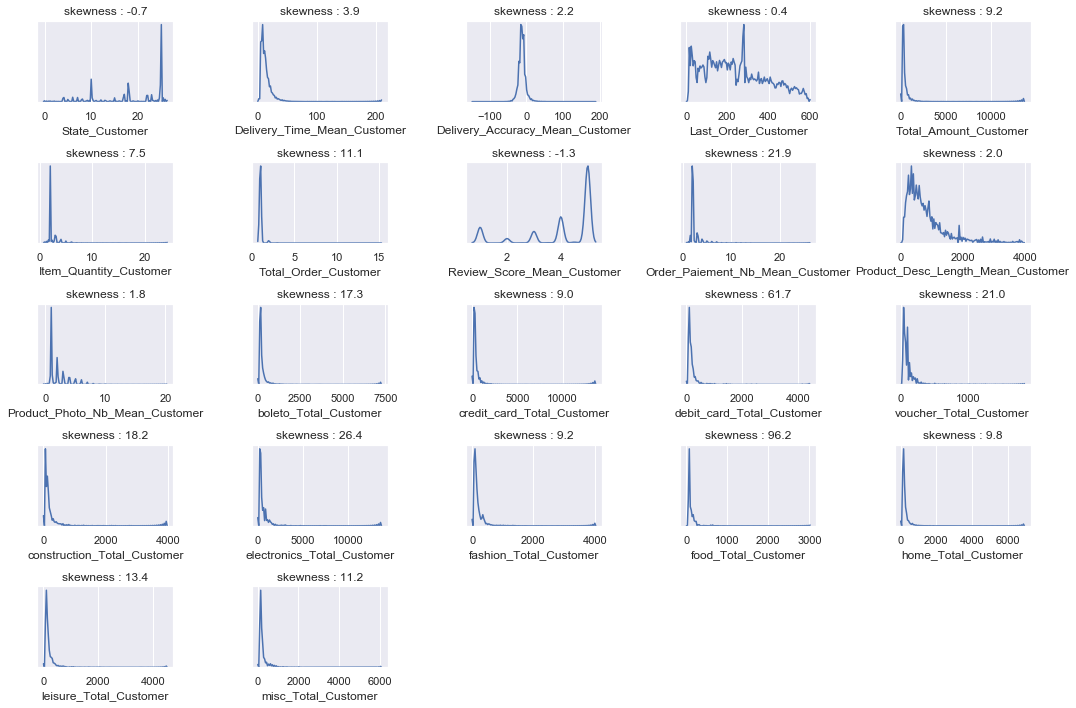

In [166]:
densite(Customer_Base)

In [167]:


def correlations(df, largeur=14, hauteur=14):

    # Table des corrélations
    corr = df.corr()

    # Add the mask to the heatmap
    plt.figure(figsize=(largeur, hauteur))

    sns.heatmap(corr, center=0, cmap=sns.color_palette("coolwarm", 7),
                linewidths=0.5,
                annot=True, annot_kws={"size":9}, fmt=".02f",square=True)

    plt.title('Matrice des corrélations', fontsize=18)
    plt.xticks(fontsize=12, rotation=90)
    plt.yticks(fontsize=12)
    plt.show()

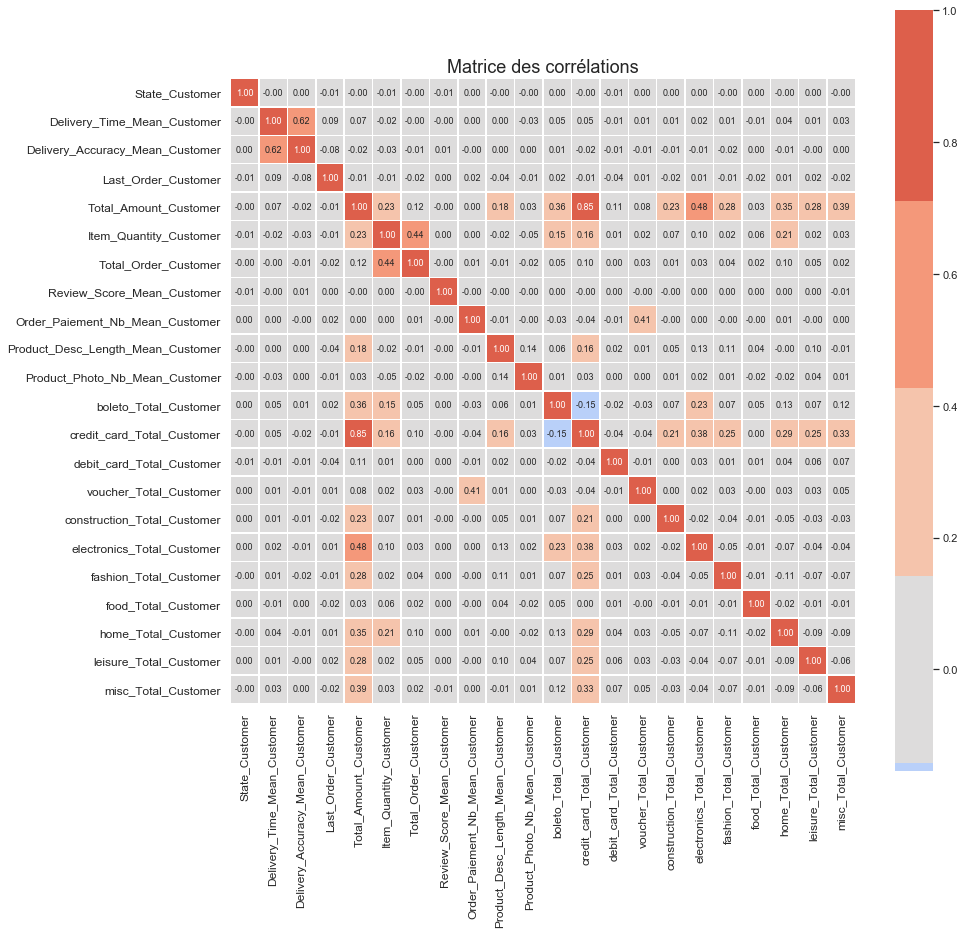

In [168]:
correlations(Customer_Base)

### 6 - [Sélection des variables et export dataframe](#6)<a class="anchor" id="6"></a>

#### 6.1 - [Passage au logarithme et sélection des variables quantitatives pour le Standard Scaler](#61)<a class="anchor" id="61"></a>

In [169]:
# On isole les variables avec un coefficient de skewness élevé (>2)
# pour les passer au log.
VarToLog = ['Total_Amount_Customer', 'Item_Quantity_Customer',
            'Total_Order_Customer', 'Order_Paiement_Nb_Mean_Customer',
            'Product_Desc_Length_Mean_Customer',
            'boleto_Total_Customer', 'credit_card_Total_Customer',
            'debit_card_Total_Customer',
            'voucher_Total_Customer',
            'construction_Total_Customer', 'electronics_Total_Customer',
            'fashion_Total_Customer',
            'food_Total_Customer', 'home_Total_Customer',
            'leisure_Total_Customer', 'misc_Total_Customer']

OtherVar = ['Last_Order_Customer', 'Review_Score_Mean_Customer',
            'Product_Photo_Nb_Mean_Customer',
            'Delivery_Accuracy_Mean_Customer', 'Delivery_Time_Mean_Customer']

Quali = ['customer_unique_id', 'State_Customer', 'order_purchase_date']

RFM = ['Total_Amount_Customer', 'Total_Order_Customer', 'Last_Order_Customer']

df_rfm = Customer_Base.loc[:, RFM].copy()
df_rfm.columns = ['Montant', 'Frequence', 'Recence']

df_other = Customer_Base.loc[:, OtherVar].copy()

df_log = np.log1p(Customer_Base.loc[:, VarToLog]).copy()

df_quali = Customer_Base.loc[:, Quali].copy()


print(df_log.shape, df_other.shape, df_quali.shape)

df_var1 = pd.concat([df_other, df_log], axis=1, join='outer')
df_var1.head()

(93104, 16) (93104, 5) (93104, 3)


,Last_Order_Customer,Review_Score_Mean_Customer,Product_Photo_Nb_Mean_Customer,Delivery_Accuracy_Mean_Customer,Delivery_Time_Mean_Customer,Total_Amount_Customer,Item_Quantity_Customer,Total_Order_Customer,Order_Paiement_Nb_Mean_Customer,Product_Desc_Length_Mean_Customer,boleto_Total_Customer,credit_card_Total_Customer,debit_card_Total_Customer,voucher_Total_Customer,construction_Total_Customer,electronics_Total_Customer,fashion_Total_Customer,food_Total_Customer,home_Total_Customer,leisure_Total_Customer,misc_Total_Customer
0,471,5.0,1.0,-11.0,8.0,4.996334,0.693147,0.693147,0.693147,7.040536,0.00000,4.996334,0.0,0.0,0.0,0.0,0.0,0.0,4.996334,0.0,0.0
1,103,4.0,1.0,1.0,26.0,5.067205,0.693147,0.693147,0.693147,6.862758,0.00000,5.067205,0.0,0.0,0.0,0.0,0.0,0.0,5.067205,0.0,0.0
2,170,5.0,1.0,-13.0,14.0,5.160778,0.693147,0.693147,0.693147,6.972606,0.00000,5.160778,0.0,0.0,0.0,0.0,0.0,0.0,5.160778,0.0,0.0
3,53,5.0,1.0,-8.0,31.0,5.758113,0.693147,0.693147,0.693147,7.029088,0.00000,5.758113,0.0,0.0,0.0,0.0,0.0,0.0,5.758113,0.0,0.0
4,515,5.0,1.0,-6.0,29.0,4.991860,0.693147,0.693147,0.693147,5.043425,4.99186,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,4.991860,0.0,0.0


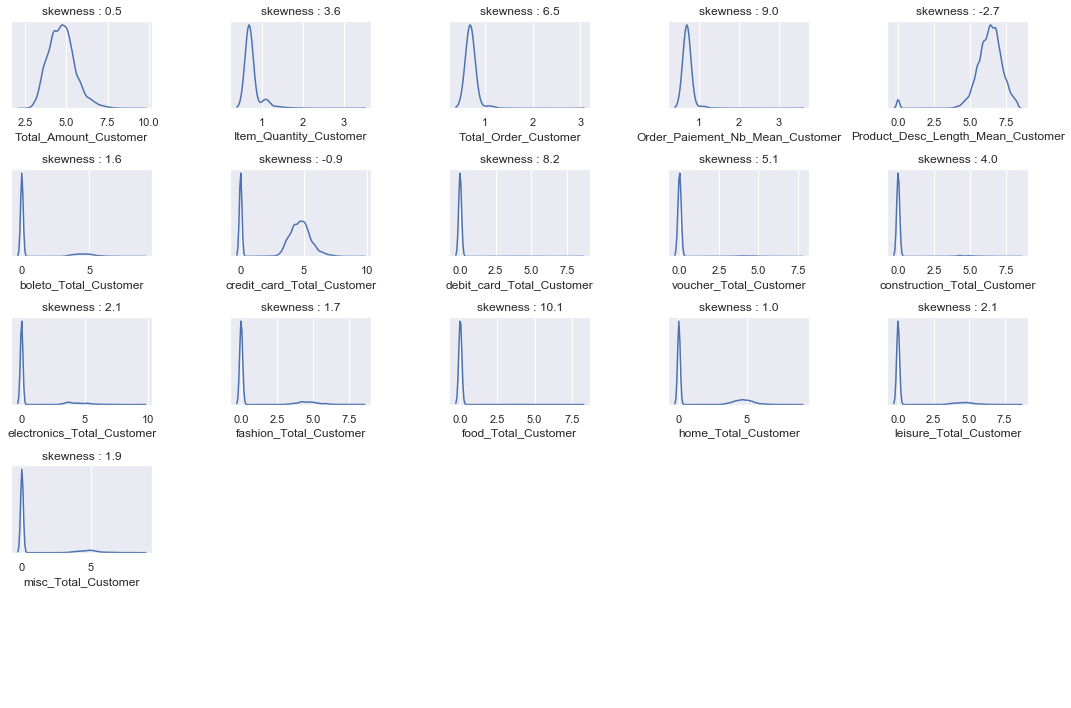

In [170]:
densite(df_log)

#### 6.2 - [Export](#62)<a class="anchor" id="62"></a>

In [171]:
Customer_Base_Export = pd.concat([df_quali, df_other,
                                  df_log, df_rfm], axis=1, join='outer')
Customer_Base_Export.shape

(93104, 27)

In [172]:
Customer_Base_Export.to_csv(path+"Customer_Base_Export.csv",
                            index=False, sep=',', encoding='utf-8')